In [1]:
import numpy as np
import sklearn
from sklearn import datasets
from sklearn import linear_model
import matplotlib.pyplot as plt


np.random.seed(0)
X,y = sklearn.datasets.make_moons(200, noise=0.2)
print(X.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

(200, 2)


# 先使用一个线性分类器

In [2]:
# 先定义函数来画决策边界
def plot_decision_boundary(pred_func):
 
    # 设定最大最小值，附加一点点边缘填充
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
 
    # 用预测函数预测一下
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
 
    # 然后画出图
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

F:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, 'Logistic Regression')

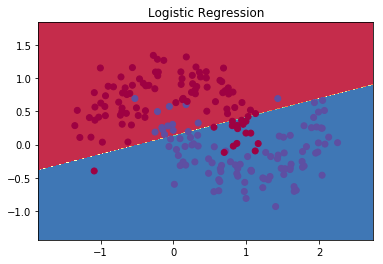

In [3]:
# 训练logistic回归模型
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

# 绘制决策边界
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

# 使用神经网络

![avater](./nn-from-scratch-3-layer-network.png)

![avater](./forward_propagation.png)

如果我们有N个训练样本，以及C个输出类别，那么我们的预测结果 $\hat{y}$ 相对于真值标签 y 的损失是这样定义的： 
  ![avater](./loss.png)

In [4]:
num_examples = len(X) #训练样本长度
nn_input_dim = 2 #输入层的维度
nn_output_dim = 2 #输出层的维度

# 梯度下降的参数
epsilon = 0.01 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度

In [5]:
#帮助我们在数据集上估算总体损失的函数 
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    #正向传播，计算预测值
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # 计算损失
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    #在损失上加上正则项（可选）
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [6]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

back propagation
![avater](./back_propagation.png)

In [9]:
# 这个函数为神经网络学习参数并且返回模型
# - nn_hdim: 隐藏层的节点数
# - num_passes: 通过训练集进行梯度下降的次数
# - print_loss: 如果是True, 那么每1000次迭代就打印一次损失值
def build_model(nn_hdim, num_passes=20000, print_loss=False):

    # 用随机值初始化参数。我们需要学习这些参数
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    print(np.shape(W1))
    print(np.shape(W2))

    # 这是我们最终要返回的数据
    model = {}

    # 梯度下降
    for i in range(0, num_passes):

        # 正向传播
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # 反向传播
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = (X.T).dot(delta2)
        db1 = np.sum(delta2, axis=0)

        # 添加正则项 (b1 和 b2 没有正则项)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # 梯度下降更新参数
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2

        # 为模型分配新的参数
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # 选择性地打印损失
        # 这种做法很奢侈，因为我们用的是整个数据集，所以我们不想太频繁地这样做
        if print_loss and i % 1000 == 0:
          print ("Loss after iteration %i: %f" %(i, calculate_loss(model)))

    return model

(2, 3)
(3, 2)
Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068890
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

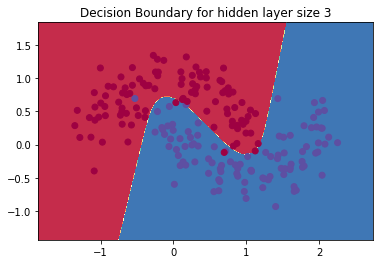

In [10]:
# 搭建一个3维隐藏层的模型
model = build_model(3, print_loss=True)

# 画出决策边界
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

In [ ]:
#改变隐藏层的大小
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()